<a href="https://colab.research.google.com/github/MaCuur/AI_EGs/blob/main/modelo_regresion_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM univariado — Predicción de precipitación (horizontes 1,3,5,7 días)

Este notebook contiene todo el flujo para entrenar modelos LSTM univariados sobre la serie `precipitacion_mm` del archivo `9020_CIUDAD DE MEXICO_9020_2020_precipitacion.csv`.

⚠️ **Nota:** Este entorno donde ejecuté la prueba **no tiene TensorFlow instalado**, por lo que no fue posible entrenar aquí. Puedes ejecutar este notebook localmente o en Google Colab (recomiendo Colab) tras instalar TensorFlow.

Instrucciones rápidas para Colab:
1. Subir `9020_CIUDAD_DE_MEXICO_9020_2020_precipitacion.csv` al panel de archivos (o montar Google Drive).
2. Ejecutar la celda siguiente para instalar dependencias:
```bash
!pip install -q tensorflow scikit-learn joblib
```
3. Ejecutar las celdas en orden.


In [ ]:
#!pip install -q tensorflow scikit-learn joblib


In [ ]:
# Cargar datos y reconstruir fecha
df = pd.read_csv("/content/9020_CIUDAD DE MEXICO_9020_2020_precipitacion.csv")
if set(['año','mes','dia']).issubset(df.columns):
    df['fecha'] = pd.to_datetime(dict(year=df['año'], month=df['mes'], day=df['dia']), errors='coerce')
else:
    date_cols = [c for c in df.columns if 'fecha' in c.lower() or 'date' in c.lower()]
    if date_cols:
        df['fecha'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
    else:
        df['fecha'] = pd.RangeIndex(start=0, stop=len(df))

df = df.sort_values('fecha').reset_index(drop=True)
print('Columnas del CSV:', df.columns.tolist())
print(df.head())


Columnas del CSV: ['precipitacion_mm', 'mes', 'dia', 'año', 'fecha']
   precipitacion_mm  mes  dia   año      fecha
0                 0    1    1  2020 2020-01-01
1                 0    1    2  2020 2020-01-02
2                 0    1    3  2020 2020-01-03
3                 0    1    4  2020 2020-01-04
4                 0    1    5  2020 2020-01-05


In [ ]:

# --- Imports y configuración ---
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# Configuración de visualización
pd.options.display.max_columns = 50
pd.options.display.width = 200
plt.rcParams['figure.figsize'] = (10,5)


In [ ]:
# --- Cargar y combinar CSVs ---
data_dir = Path("")
csv_files = sorted(glob.glob(str(data_dir / "*.csv")))

# Si no se encuentran archivos en la carpeta, intentar usar el CSV de ejemplo subido
if len(csv_files) == 0 and Path("/mnt/data/9020_CIUDAD DE MEXICO_9020_2020_precipitacion.csv").exists():
    csv_files = [str(Path("/mnt/data/9020_CIUDAD DE MEXICO_9020_2020_precipitacion.csv"))]

print(f"Encontrados {len(csv_files)} archivos CSV. Ejemplo: {csv_files[:3]}")

def read_precip_csv(path):
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    expected = ['precipitacion_mm','mes','dia','año']
    if not all(col in df.columns for col in expected):
        raise ValueError(f"El archivo {path} no contiene las columnas esperadas. Columnas encontradas: {df.columns.tolist()}")
    df['mes'] = df['mes'].astype(int)
    df['dia'] = df['dia'].astype(int)
    df['año'] = df['año'].astype(int)
    # Ensure the dictionary keys match the expected arguments for pd.to_datetime when assembling from units
    df['fecha'] = pd.to_datetime({'year': df['año'], 'month': df['mes'], 'day': df['dia']})
    df = df[['fecha','precipitacion_mm']].copy()
    return df

dfs = [read_precip_csv(p) for p in csv_files]
data = pd.concat(dfs, ignore_index=True)
data = data.groupby('fecha', as_index=False)['precipitacion_mm'].sum()
data = data.sort_values('fecha').reset_index(drop=True)

print('Rango de fechas:', data['fecha'].min(), 'a', data['fecha'].max())
data.head()

Encontrados 69 archivos CSV. Ejemplo: ['9020_CIUDAD DE MEXICO_9020_1952_precipitacion.csv', '9020_CIUDAD DE MEXICO_9020_1953_precipitacion.csv', '9020_CIUDAD DE MEXICO_9020_1954_precipitacion.csv']
Rango de fechas: 1952-01-01 00:00:00 a 2020-12-31 00:00:00


,fecha,precipitacion_mm
0,1952-01-01,0.0
1,1952-01-02,0.0
2,1952-01-03,0.0
3,1952-01-04,0.0
4,1952-01-05,0.0


In [ ]:

# --- Asegurar continuidad diaria ---
data = data.set_index('fecha').asfreq('D').fillna(0.0).rename_axis('fecha').reset_index()
print('Registros tras asegurar frecuencia diaria:', len(data))
data.head()


Registros tras asegurar frecuencia diaria: 25203


,fecha,precipitacion_mm
0,1952-01-01,0.0
1,1952-01-02,0.0
2,1952-01-03,0.0
3,1952-01-04,0.0
4,1952-01-05,0.0


In [ ]:
# --- Construir ventanas y conjuntos X,y ---
WINDOW = 30
HORIZONS = [1,3,5,7]

def make_dataset(series, window, horizon):
    X = []
    y = []
    dates = []
    vals = series.values
    for i in range(window, len(vals) - horizon + 1):
        X.append(vals[i-window:i])
        y.append(vals[i + horizon - 1])
        dates.append(series.index[i + horizon - 1])
    return np.array(X), np.array(y), np.array(dates)

serie = pd.Series(data['precipitacion_mm'].values, index=pd.DatetimeIndex(data['fecha']))

for h in HORIZONS:
    Xh, yh, dh = make_dataset(serie, WINDOW, h)
    print(f'Horizonte {h}: X {Xh.shape}, y {yh.shape}')

Horizonte 1: X (25173, 30), y (25173,)
Horizonte 3: X (25171, 30), y (25171,)
Horizonte 5: X (25169, 30), y (25169,)
Horizonte 7: X (25167, 30), y (25167,)



Procesando horizonte: 1 días
Horizonte 1 — MSE (train/test): 40.6496 / 12.3071 — MAE (train/test): 3.2686 / 1.5185


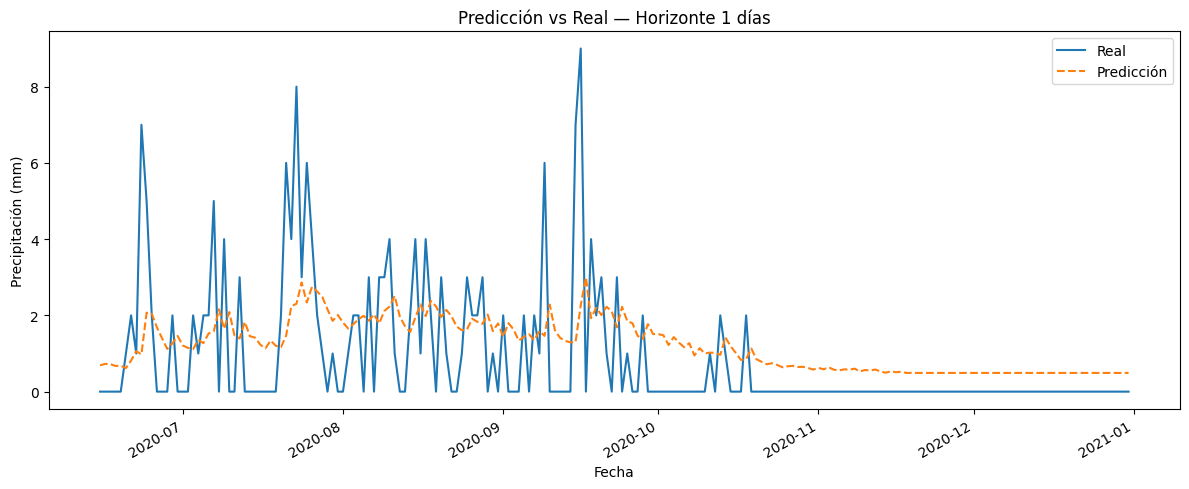


Procesando horizonte: 3 días
Horizonte 3 — MSE (train/test): 42.0671 / 12.9177 — MAE (train/test): 3.3984 / 1.6491


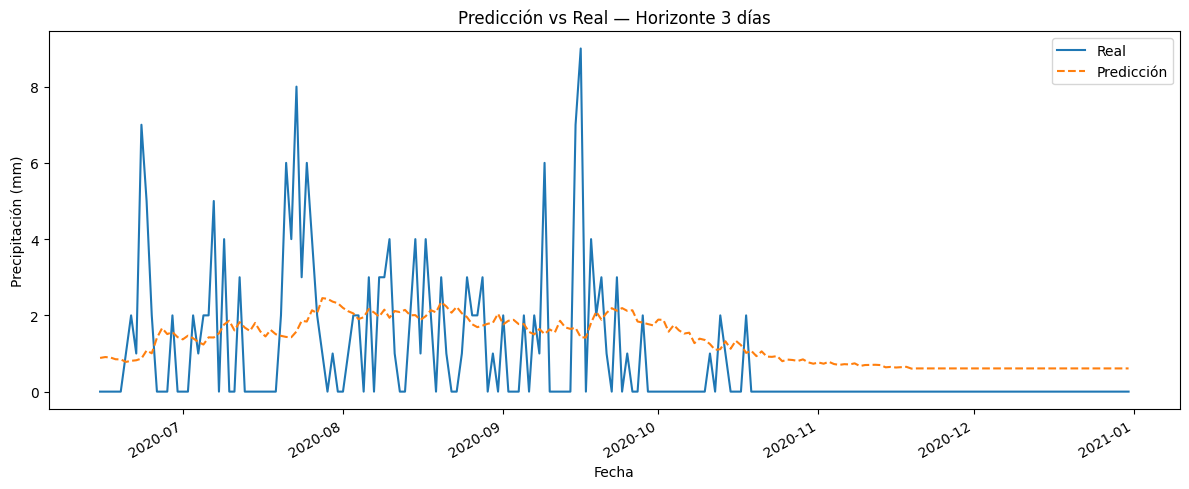


Procesando horizonte: 5 días
Horizonte 5 — MSE (train/test): 42.3768 / 13.1507 — MAE (train/test): 3.4311 / 1.6985


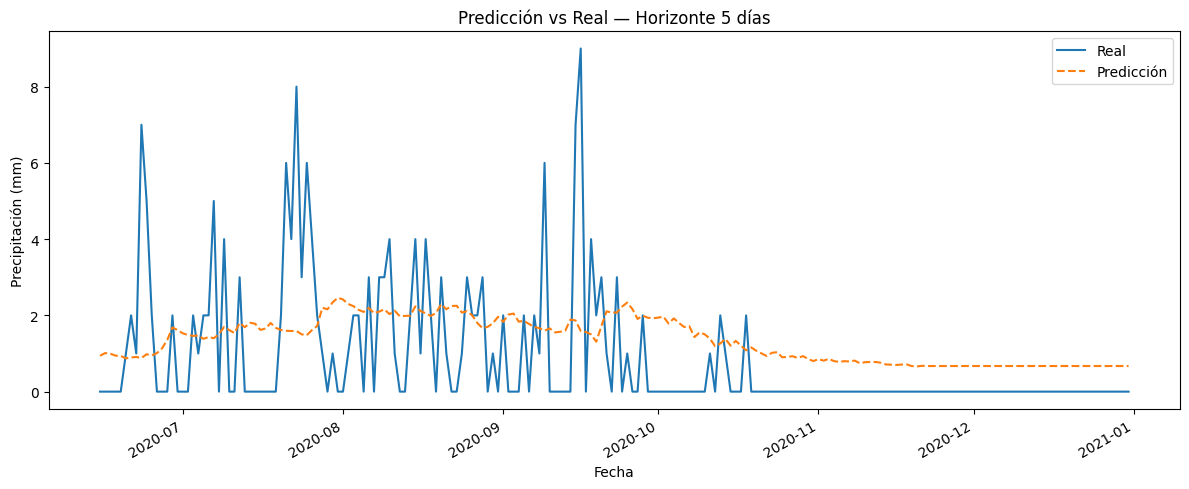


Procesando horizonte: 7 días
Horizonte 7 — MSE (train/test): 42.6559 / 13.2789 — MAE (train/test): 3.4610 / 1.7314


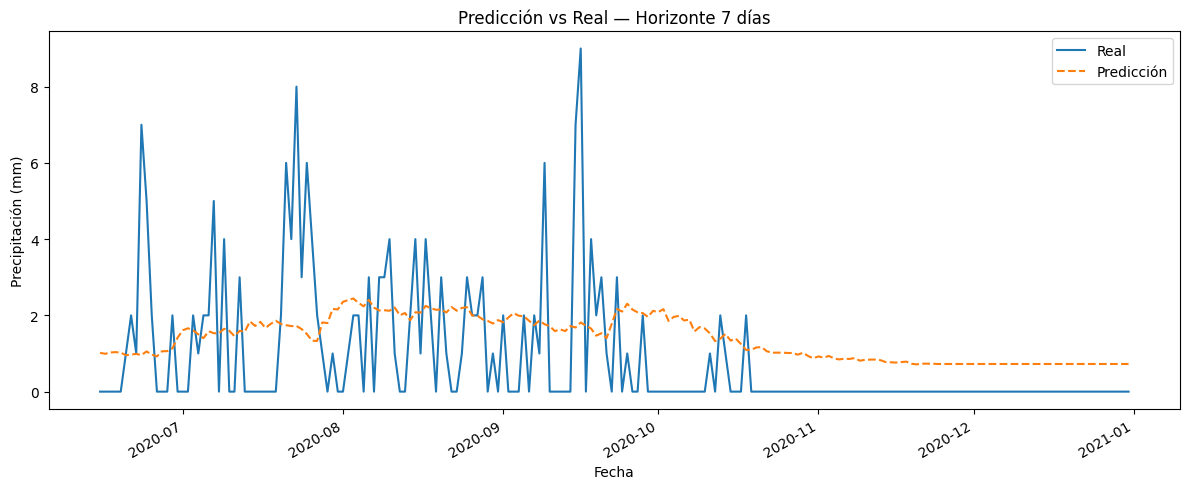


Métricas guardadas en resultados/metrics_summary.csv


In [ ]:

# --- Entrenamiento y evaluación por horizonte ---
resultados_dir = Path('resultados')
resultados_dir.mkdir(parents=True, exist_ok=True)

metrics_summary = []  # guardaremos MSE/MAE por horizonte y conjunto (train/test)

for horizon in HORIZONS:
    print('\n' + '='*40)
    print(f'Procesando horizonte: {horizon} días')
    X, y, dates = make_dataset(serie, WINDOW, horizon)
    # Convertir X a formato 2D (cada ventana como vector plano)
    nsamples = X.shape[0]
    X2 = X.reshape(nsamples, WINDOW)

    # Dividir en train/test manteniendo orden temporal (no shuffling)
    split_idx = int(0.8 * len(X2))
    X_train, X_test = X2[:split_idx], X2[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    dates_train, dates_test = dates[:split_idx], dates[split_idx:]

    # Escalador + regresión lineal
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X_train, y_train)

    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Métricas
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    print(f'Horizonte {horizon} — MSE (train/test): {mse_train:.4f} / {mse_test:.4f} — MAE (train/test): {mae_train:.4f} / {mae_test:.4f}')

    # Guardar métricas
    metrics_summary.append({
        'horizon': int(horizon),
        'mse_train': float(mse_train),
        'mse_test': float(mse_test),
        'mae_train': float(mae_train),
        'mae_test': float(mae_test)
    })

    # Guardar modelo
    model_path = resultados_dir / f'model_horizon_{horizon}.joblib'
    joblib.dump(model, model_path)

    # Guardar predicciones en CSV
    df_preds = pd.DataFrame({
        'fecha': dates_test,
        'y_true': y_test,
        'y_pred': y_pred_test
    })
    df_preds.to_csv(resultados_dir / f'preds_horizon_{horizon}.csv', index=False)

    # Graficar predicción vs real (últimos 200 puntos de test para claridad)
    n_display = min(200, len(df_preds))
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(df_preds['fecha'][-n_display:], df_preds['y_true'][-n_display:], label='Real')
    ax.plot(df_preds['fecha'][-n_display:], df_preds['y_pred'][-n_display:], label='Predicción', linestyle='--')
    ax.set_title(f'Predicción vs Real — Horizonte {horizon} días')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Precipitación (mm)')
    ax.legend()
    fig.autofmt_xdate()
    plt.tight_layout()
    png_path = resultados_dir / f'pred_vs_real_h{horizon}.png'
    fig.savefig(png_path)
    plt.show()

# Guardar resumen de métricas
metrics_df = pd.DataFrame(metrics_summary).sort_values('horizon').reset_index(drop=True)
metrics_df.to_csv(resultados_dir / 'metrics_summary.csv', index=False)
print('\nMétricas guardadas en', str(resultados_dir / Path('metrics_summary.csv')))


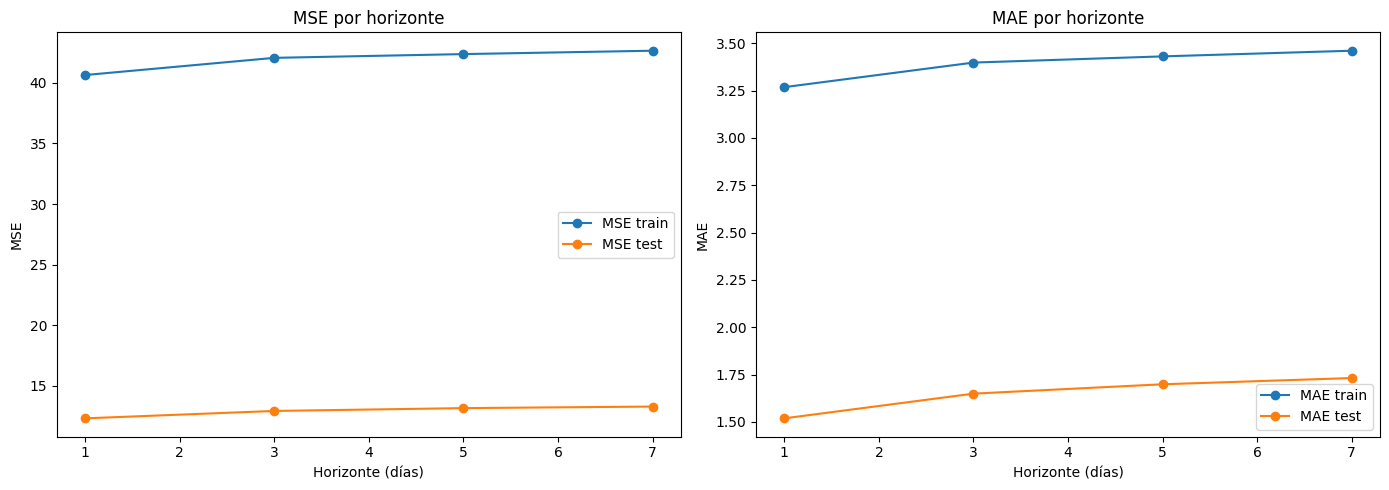

In [ ]:

# --- Plots de MSE y MAE por horizonte (train/test) ---
metrics = pd.read_csv('resultados/metrics_summary.csv')
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(metrics['horizon'], metrics['mse_train'], marker='o', label='MSE train')
ax[0].plot(metrics['horizon'], metrics['mse_test'], marker='o', label='MSE test')
ax[0].set_title('MSE por horizonte')
ax[0].set_xlabel('Horizonte (días)')
ax[0].set_ylabel('MSE')
ax[0].legend()

ax[1].plot(metrics['horizon'], metrics['mae_train'], marker='o', label='MAE train')
ax[1].plot(metrics['horizon'], metrics['mae_test'], marker='o', label='MAE test')
ax[1].set_title('MAE por horizonte')
ax[1].set_xlabel('Horizonte (días)')
ax[1].set_ylabel('MAE')
ax[1].legend()

plt.tight_layout()
plt.savefig('resultados/metrics_plots.png')
plt.show()


In [ ]:
# Preparar serie univariada
target_col = 'precipitacion_mm'
series = data[[ 'fecha', target_col ]].copy()
series[target_col] = pd.to_numeric(series[target_col], errors='coerce').fillna(0.0)

scaler = StandardScaler()
scaled_vals = scaler.fit_transform(series[[target_col]].values)
RESULT_DIR = resultados_dir # Define RESULT_DIR here
joblib.dump(scaler, os.path.join(RESULT_DIR, 'scaler_univariado.pkl'))

def create_sequences_univar(arr, seq_len, horizon):
    X, y = [], []
    n = len(arr)
    for i in range(n - seq_len - horizon + 1):
        X.append(arr[i:i+seq_len].reshape(seq_len, 1))
        y.append(arr[i+seq_len:i+seq_len+horizon])
    return np.array(X), np.array(y)

print('Preparado. Datos escalados y scaler guardado en', os.path.join(RESULT_DIR, 'scaler_univariado.pkl'))

Preparado. Datos escalados y scaler guardado en resultados/scaler_univariado.pkl


## Qué entregará este notebook
- Modelos guardados: `lstm_univar_h{h}.h5` por cada horizonte
- Scaler: `scaler_univariado.pkl`
- CSVs con predicciones: `predicciones_h{h}.csv`
- Gráficas `pred_vs_real_h{h}.png` y `train_loss_h{h}.png`

### Nota final
Si quieres, puedo ahora:
1. Guardar este notebook en `/mnt/data/` para que lo descargues. (ya lo hice abajo)
2. Preparar un `README` corto con instrucciones paso a paso para ejecutarlo en Colab.
